# 1- Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

!pip install torchmetrics
import torchmetrics

Set seeds for reproducibility:

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

# 2- Using convolutions in PyTorch

Defining and using a convolution using object oriented programming: (Note: PyTorch will keep track of the filter weights automatically, as long as you create an instance of a of the Conv2d class).

In [ ]:
# Create 1 random image of shape (1, 28, 28)
image = torch.rand(1, 28, 28)

# Create a convolutional that applies 6 3x3 filters to get 6 output channels (Stride = 1, same padding)
conv_filters = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), stride=1, padding="same")

# Convolve the image with the filters
output = conv_filters(image)
print(output.shape)

torch.Size([6, 28, 28])


We can also define a max-pooling operation as follows:

In [ ]:
# We can create an image
image = torch.rand(1, 6, 6)

# Apply a 2x2 max pool filter
output = F.max_pool2d(image, 2)
print(output.shape)

torch.Size([1, 1, 3, 3])


# 3- Dataset

From Kaggle:
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

Read more [here](https://www.kaggle.com/c/digit-recognizer).


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

About using PyTorch datasets & dataloaders:

From the official PyTorch documentation: "Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples."

Read more [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

We start by loading the train / test portions of the data:

In [ ]:
# Transform the data to torch tensors and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and standard deviation of the dataset to use for normalization
])

# Preparing the training, validation, and test sets
train_and_val_sets = torchvision.datasets.MNIST('mnist', train=True, download=True, transform=transform) # Will be split into training and validation for hyperparameter tuning
train_set, val_set = torch.utils.data.random_split(train_and_val_sets, [55000, 5000]) # 55000 training examples, 5000 validation examples
test_set = torchvision.datasets.MNIST('mnist', train=False, download=True, transform=transform)

# Prepare loaders which will give us the data batch by batch (Here, batch size is 8)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

# Print the size of each of the datasets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 55000
Validation set size: 5000
Testing set size: 10000


We an then visualize an image of the training set and its label:

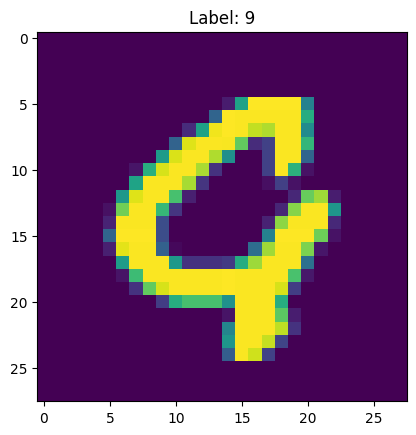

In [ ]:
for images, labels in train_loader:
  plt.imshow(images[0].permute(1, 2, 0))
  plt.title(f"Label: {labels[0]}")
  break

Our data pre-processing works!

# 4- MLP

## A) Implementing the model

We will first see how to solve this problem using an MLP. We first implement the following model in code:
- A flattening operation to size 784 (Since images are 28 * 28 pixels)
- Input layer of size 784
- Hidden layer of 100 units
- Relu activation
- Hidden layer of 50 units
- Relu activation
- Output unit of 10 units
- Softmax activation

In [ ]:
class MLP(nn.Module):
  '''
    Class representing a multilayer perceptron with 2 hidden layers of sizes 100, 50 and 1 output layer of size 10 (10 classes)
  '''
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(28*28, 100) # Images are 28 * 28 pixels, the first hidden layer has size 100
    self.layer2 = nn.Linear(100, 50)
    self.layer3 = nn.Linear(50, 10) # Narrow down progressively to 10 since have 10 classes


  def forward(self, x):
    '''Forward pass function, needs to be defined for every model'''
    x = torch.flatten(x, start_dim = 1) # Since the inputs are images, we need to flatten them into 1D vectors first
    x = self.layer1(x)
    x = F.relu(x)
    x = self.layer2(x)
    x = F.relu(x)
    x = self.layer3(x)
    x = F.softmax(x, dim = 1) # dim = 1 to softmax along the rows of the output (We want the probabilities of all classes to sum up to 1)
    return x

For simplicity, we will try 2 different values of the learning rate for the hyperarameter tuning:

In [ ]:
lr_values = {0.01, 0.1}
num_epochs = 2 # We will go through the whole training dataset 2 times during training
num_iterations_before_validation = 1000 # We will compute the validation accuracy every 1000 iterations

## B) Defining the training loop:

First, we can check for the presence of GPU (Go to Runtime > Change runtime type > Activate the GPU option).

In [ ]:
# If a GPU is available, use it
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")

# Else, revert to the default (CPU)
else:
  DEVICE = torch.device("cpu")

print(DEVICE)

cuda


If you set this up properly, you should see cuda get printed above.

Great! We now have a GPU to use for computational power.

We can now define the loss & accuracy functions:

In [ ]:
loss = nn.CrossEntropyLoss().to(DEVICE) # Since we are doing multiclass classification
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(DEVICE) # Regular accuracy

We can then proceed to train the model using the following training loop:

In [ ]:
# To track the validation metrics for each of the two hyperparameters, as well as the trained model for each
mlp_metrics = {}
mlp_models = {}

for lr in lr_values:

  # Create empty lists of tracking the validation loss / accuracy throughout iterations for this hyperparameter
  mlp_metrics[lr] = {
      "accuracies": [],
      "losses": []
  }

  # Initialize an MLP and attach a Stochastic Gradient Descent optimizer to its weights
  # Note: The optimizer defines the formula to use to update the weights
  # SGD is just plain gradient descent, an improvement is the Adam gradient descent
  mlp = MLP().to(DEVICE)
  optimizer = optim.SGD(mlp.parameters(), lr)

  # Store the model inside of the models dictionary
  mlp_models[lr] = mlp

  # Iterate through the epochs
  for epoch in range(num_epochs):

    # Iterate through the training data
    for iteration, (X_train, y_train) in enumerate(train_loader):

      # Move the batch to GPU if it's available
      X_train = X_train.to(DEVICE)
      y_train = y_train.to(DEVICE)

      # The optimizer accumulates the gradient of each weight as we do forward passes -> zero_grad resets all gradients to 0
      optimizer.zero_grad()

      # Compute a forward pass and make a prediction
      # Note that calling mlp(X) is equivalent to calling mlp.foward(X) (Benefit of extending nn.Module)
      y_hat = mlp(X_train)

      # Compute the loss
      train_loss = loss(y_hat, y_train)

      # Compute the gradients in the optimizer
      # Calling "backward" on the loss populates the gradients that the optimizer keeps track of
      train_loss.backward()

      # The step function uses the computed gradients to update the weights
      # It follows the strategy of the specified optimizer (In this case, plain SGD)
      optimizer.step()

      # Check if should compute the validation metrics for plotting later
      if iteration % num_iterations_before_validation == 0:

        # Stop computing gradients on the validation set, we don't want the model to learn from this / just track the loss & accuracy
        with torch.no_grad():

          # Keep track of the losses & accuracies
          val_accuracy_sum = 0
          val_loss_sum = 0

          # Make a predictions on the full validation set, batch by batch
          for X_val, y_val in val_loader:

            # Move the batch to GPU if it's available
            X_val = X_val.to(DEVICE)
            y_val = y_val.to(DEVICE)

            y_hat = mlp(X_val)
            val_accuracy_sum += accuracy(y_hat, y_val)
            val_loss_sum += loss(y_hat, y_val)

          # Divide by the number of iterations (and move back to CPU)
          val_accuracy = (val_accuracy_sum / len(val_loader)).cpu()
          val_loss = (val_loss_sum / len(val_loader)).cpu()

          # Store the values in the dictionary
          mlp_metrics[lr]["accuracies"].append(val_accuracy)
          mlp_metrics[lr]["losses"].append(val_loss)

          # Print to console
          print(f"LR = {lr} --- EPOCH = {epoch} --- ITERATION = {iteration}")
          print(f"Validation loss = {val_loss} --- Validation accuracy = {val_accuracy}")

LR = 0.1 --- EPOCH = 0 --- ITERATION = 0
Validation loss = 2.3007287979125977 --- Validation accuracy = 0.14919999241828918
LR = 0.1 --- EPOCH = 0 --- ITERATION = 1000
Validation loss = 1.6553667783737183 --- Validation accuracy = 0.8113999962806702
LR = 0.1 --- EPOCH = 0 --- ITERATION = 2000
Validation loss = 1.612001657485962 --- Validation accuracy = 0.8527999520301819
LR = 0.1 --- EPOCH = 0 --- ITERATION = 3000
Validation loss = 1.5498046875 --- Validation accuracy = 0.9125999808311462
LR = 0.1 --- EPOCH = 0 --- ITERATION = 4000
Validation loss = 1.5450986623764038 --- Validation accuracy = 0.9163999557495117
LR = 0.1 --- EPOCH = 0 --- ITERATION = 5000
Validation loss = 1.5314326286315918 --- Validation accuracy = 0.9305999875068665
LR = 0.1 --- EPOCH = 0 --- ITERATION = 6000
Validation loss = 1.529414176940918 --- Validation accuracy = 0.9321999549865723
LR = 0.1 --- EPOCH = 1 --- ITERATION = 0
Validation loss = 1.5372544527053833 --- Validation accuracy = 0.9251999855041504
LR = 

## C) Visualizing the results

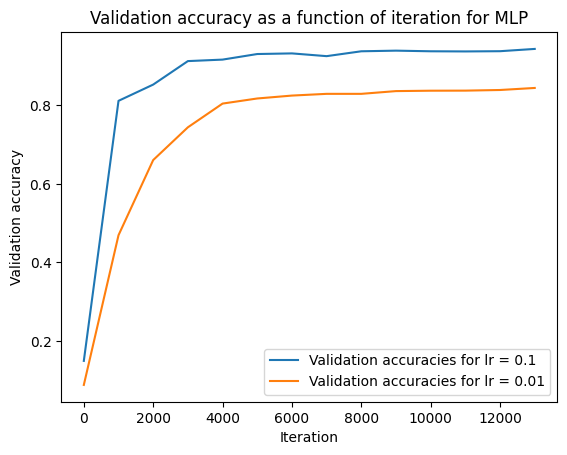

In [ ]:
# Create an array of values spaced by num_iterations_before_validation up to the number of samples taken for the x_axis of the plots
x_axis = np.arange(0, len(mlp_metrics[0.1]["accuracies"]) * num_iterations_before_validation, num_iterations_before_validation)

# Plot the accuracies as a function of iterations
plt.plot(x_axis, mlp_metrics[0.1]["accuracies"], label = "Validation accuracies for lr = 0.1")
plt.plot(x_axis, mlp_metrics[0.01]["accuracies"], label = "Validation accuracies for lr = 0.01")
plt.xlabel("Iteration")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy as a function of iteration for MLP")
plt.legend()

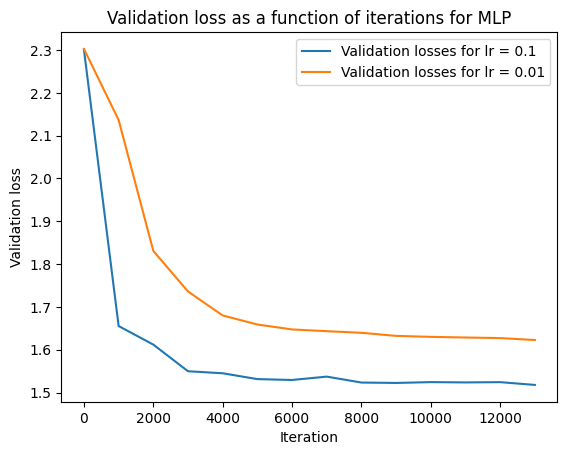

In [ ]:
# Plot the losses as a function of iterations
plt.plot(x_axis, mlp_metrics[0.1]["losses"], label = "Validation losses for lr = 0.1")
plt.plot(x_axis, mlp_metrics[0.01]["losses"], label = "Validation losses for lr = 0.01")
plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.title("Validation loss as a function of iterations for MLP")
plt.legend()

Clearly, 0.1 performs much better than 0.01 because it converges faster, meaning it can achieve better results within 2 epochs. We also see that the loss function decreases on average, so lr = 0.1 is not too large (No overshooting). We can now use the best model (lr = 0.1) to get a testing accuracy:

In [ ]:
test_accuracy_sum = 0
best_mlp = mlp_models[0.1] # Extract the trained model with learning rate 0.1

for X_test, y_test in test_loader:

  # Move batch to GPU
  X_test = X_test.to(DEVICE)
  y_test = y_test.to(DEVICE)

  # Make prediction
  y_hat = best_mlp(X_test)

  # Calculate accuracy
  test_accuracy_sum += accuracy(y_hat, y_test)

# Divide by the number of batches in the test set
test_accuracy = (test_accuracy_sum / len(test_loader)).cpu()
print(f"The test set accuracy of the best model is: {test_accuracy}")


The test set accuracy of the best model is: 0.9312999844551086


We get a testing accuracy very similar to our validation accuracy (Both around 93-94%), showing the model didn't overfit!

# 5- CNN

## A) Implementing the model

We will implement the following model in code:
- Input layer of size 28 * 28
- Convolution with a 3x3 filter and 5 output channels, same padding
- Relu activation
- 2x2 max pooling
- Convolution with a 3x3 filter and 10 output channels, same padding
- Relu activation
- 2x2 max pooling
- Convolution with a 3x3 filter and 20 output channels, same padding
- Relu activation
- 2x2 max pooling
- A flattening operation
- An output layer of 10 units (linear)
- Softmax activation

In [ ]:
class CNN(nn.Module):
  '''
    Class representing a CNN with 2 (convolutional + activation + maxpooling) layers, connected to a single linear layer for prediction
  '''
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding="same") # Outputs 5 channels
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding="same") # Outputs 10 channels
    self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding="same") # Outputs 20 channels
    self.linear = nn.Linear(180, 10) # How did we know that the flattened output will have 490 after 2 convolution layers and 2 maxpool layers? Trial and error! Try running a forward pass with a different number (Not 180)
                                     # Say you first try 3920: Get an error -> mat1 and mat2 shapes cannot be multiplied (8x180 and 3920x10) -> Now we know each of the 8 samples in the batch has size 180 after flattening
                                     # We can then change 3920 to 180 :)

  def forward(self, x):
    '''Forward pass function, needs to be defined for every model'''

    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # 2x2 maxpool

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = torch.flatten(x, start_dim = 1) # Flatten to a 1D vector
    x = self.linear(x)
    x = F.softmax(x, dim = 1) # dim = 1 to softmax along the rows of the output (We want the probabilities of all classes to sum up to 1)

    return x

Next, we define hyperparameters we will try. We will go for learning rates of 0.01 and 0.001 since our optimizer is Adam this time (Which traverses the loss function faster, see [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) for more information). (You are encouraged to try fine-tuning different hyperparameters of this model using the validation set to get better testing accuracies after class).

In [ ]:
lr_values = {0.01, 0.001}
num_epochs = 2 # We will go through the whole training dataset 2 times during training to be fair in the comparison to MLP
num_iterations_before_validation = 1000 # We will compute the validation accuracy every 1000 iterations

## B) Defining the training loop

In [ ]:
cnn_metrics = {}
cnn_models = {}

for lr in lr_values:

  cnn_metrics[lr] = {
      "accuracies": [],
      "losses": []
  }

  cnn = CNN().to(DEVICE)
  optimizer = optim.Adam(cnn.parameters(), lr)
  cnn_models[lr] = cnn

  # Iterate through the epochs
  for epoch in range(num_epochs):

    # Iterate through the training data
    for iteration, (X_train, y_train) in enumerate(train_loader):

      # Move the batch to GPU if it's available
      X_train = X_train.to(DEVICE)
      y_train = y_train.to(DEVICE)

      # The optimizer accumulates the gradient of each weight as we do forward passes -> zero_grad resets all gradients to 0
      optimizer.zero_grad()

      # Compute a forward pass and make a prediction
      y_hat = cnn(X_train)

      # Compute the loss
      train_loss = loss(y_hat, y_train)

      # Compute the gradients in the optimizer
      train_loss.backward()

      # Update the weights
      optimizer.step()

      # Check if should compute the validation metrics for plotting later
      if iteration % num_iterations_before_validation == 0:

        # Don't compute gradients on the validation set
        with torch.no_grad():

          # Keep track of the losses & accuracies
          val_accuracy_sum = 0
          val_loss_sum = 0

          # Make a predictions on the full validation set, batch by batch
          for X_val, y_val in val_loader:

            # Move the batch to GPU if it's available
            X_val = X_val.to(DEVICE)
            y_val = y_val.to(DEVICE)

            y_hat = cnn(X_val)
            val_accuracy_sum += accuracy(y_hat, y_val)
            val_loss_sum += loss(y_hat, y_val)

          # Divide by the number of iterations (and move back to CPU)
          val_accuracy = (val_accuracy_sum / len(val_loader)).cpu()
          val_loss = (val_loss_sum / len(val_loader)).cpu()

          # Store the values in the dictionary
          cnn_metrics[lr]["accuracies"].append(val_accuracy)
          cnn_metrics[lr]["losses"].append(val_loss)

          # Print to console
          print(f"LR = {lr} --- EPOCH = {epoch} --- ITERATION = {iteration}")
          print(f"Validation loss = {val_loss} --- Validation accuracy = {val_accuracy}")

LR = 0.01 --- EPOCH = 0 --- ITERATION = 0
Validation loss = 2.2987754344940186 --- Validation accuracy = 0.10439999401569366
LR = 0.01 --- EPOCH = 0 --- ITERATION = 1000
Validation loss = 1.9921964406967163 --- Validation accuracy = 0.4681999981403351
LR = 0.01 --- EPOCH = 0 --- ITERATION = 2000
Validation loss = 1.9862854480743408 --- Validation accuracy = 0.4747999906539917
LR = 0.01 --- EPOCH = 0 --- ITERATION = 3000
Validation loss = 2.089097499847412 --- Validation accuracy = 0.3718000054359436
LR = 0.01 --- EPOCH = 0 --- ITERATION = 4000
Validation loss = 1.986645221710205 --- Validation accuracy = 0.47439998388290405
LR = 0.01 --- EPOCH = 0 --- ITERATION = 5000
Validation loss = 1.9811122417449951 --- Validation accuracy = 0.47999998927116394
LR = 0.01 --- EPOCH = 0 --- ITERATION = 6000
Validation loss = 1.9742101430892944 --- Validation accuracy = 0.4869999885559082
LR = 0.01 --- EPOCH = 1 --- ITERATION = 0
Validation loss = 1.9731045961380005 --- Validation accuracy = 0.487999

## C) Visualizing results

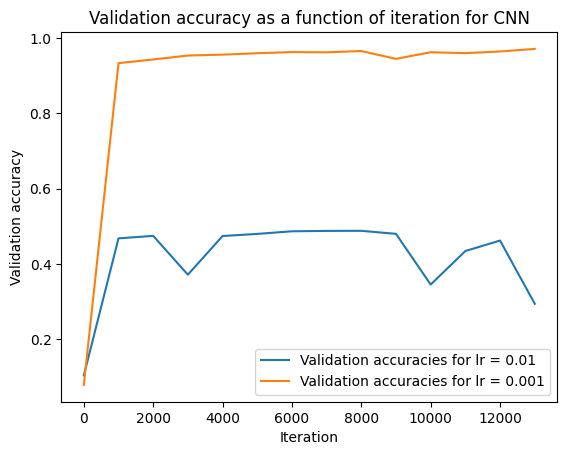

In [ ]:
# Plot the accuracies as a function of iterations
plt.plot(x_axis, cnn_metrics[0.01]["accuracies"], label = "Validation accuracies for lr = 0.01")
plt.plot(x_axis, cnn_metrics[0.001]["accuracies"], label = "Validation accuracies for lr = 0.001")
plt.xlabel("Iteration")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy as a function of iteration for CNN")
plt.legend()

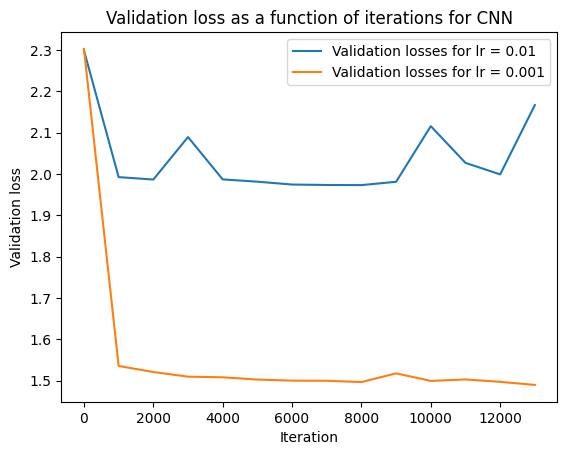

In [ ]:
# Plot the losses as a function of iterations
plt.plot(x_axis, cnn_metrics[0.01]["losses"], label = "Validation losses for lr = 0.01")
plt.plot(x_axis, cnn_metrics[0.001]["losses"], label = "Validation losses for lr = 0.001")
plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.title("Validation loss as a function of iterations for CNN")
plt.legend()

Clearly, lr = 0.001 performs better than lr = 0.01. This is because, using Adam gradient descent, the update process takes bigger steps on average, meaning that 0.01 is too large and overshoots (As can be seen above, the loss function for lr = 0.01 oscillates and diverges). This highlights the importance of hyperparameter tuning in selecting the correct learning rate. We can use the best model to find the final testing accuracy:

In [ ]:
test_accuracy_sum = 0
best_cnn = cnn_models[0.001] # Extract the best trained model

for X_test, y_test in test_loader:

  # Move batch to GPU
  X_test = X_test.to(DEVICE)
  y_test = y_test.to(DEVICE)

  # Make prediction
  y_hat = best_cnn(X_test)

  # Calculate accuracy
  test_accuracy_sum += accuracy(y_hat, y_test)

# Divide by the number of batches in the test set
test_accuracy = (test_accuracy_sum / len(test_loader)).cpu()
print(f"The test set accuracy of the best model is: {test_accuracy}")


The test set accuracy of the best model is: 0.9767999649047852


No overfitting here either (Both the final validation accuracy and the testing accuracy are both around 97-98%). We see that the CNN model outperforms the MLP by around 5% in testing accuracy! To check whether this comparison was fair, we can finally compare the number of parameters in each of the 2 models:

In [ ]:
total_params_mlp = sum(
	param.numel() for param in best_mlp.parameters()
)

total_params_cnn = sum(
	param.numel() for param in best_cnn.parameters()
)

print(f"Number of weights in the MLP: {total_params_mlp}")
print(f"Number of weights in the CNN: {total_params_cnn}")


Number of weights in the MLP: 84060
Number of weights in the CNN: 4140


The CNN model has around 80000 less parameters and well outperform the MLP. This is why CNNs are the first choice when it comes to image processing.